In [1]:
from moviepy.editor import VideoFileClip
import os

# Path to the uploaded video file
video_file_path = "/content/bbb9db78-13bb-4c88-994c-c79244ce8c94_1692011832357.mp4"
output_audio_path = "/content/extracted_audio.mp3"

# Extract audio from video
def extract_audio(video_path, audio_output_path):
    try:
        # Load the video file
        video = VideoFileClip(video_path)

        # Extract and save the audio
        video.audio.write_audiofile(audio_output_path)
        print(f"Audio successfully extracted to: {audio_output_path}")

    except Exception as e:
        print(f"An error occurred: {e}")

# Execute the function
extract_audio(video_file_path, output_audio_path)


  if event.key is 'enter':



MoviePy - Writing audio in /content/extracted_audio.mp3


MoviePy - Done.
Audio successfully extracted to: /content/extracted_audio.mp3


In [4]:
#!pip install mediapipe

MoviePy - Writing audio in /content/extracted_audio.mp3


MoviePy - Done.
Audio successfully extracted to: /content/extracted_audio.mp3


  pose_df['Tempo'] = float(audio_features['Tempo'])  # Force as scalar



Extracted Features DataFrame:
   Frame  Head Tilt  Body Movement  Blink Ratio  Skin Signal    Avg Pitch  \
0    370   0.072011       0.345715     0.017647     0.000000  1470.985229   
1    371   0.070759       0.347594     0.020572     0.062791  1470.985229   
2    372   0.069669       0.344584     0.018719     0.125333  1470.985229   
3    373   0.069884       0.350576     0.018140     0.187381  1470.985229   
4    374   0.070099       0.355419     0.018540     0.248690  1470.985229   

        Tempo  
0  123.046875  
1  123.046875  
2  123.046875  
3  123.046875  
4  123.046875  
DataFrame saved to: /content/body_language_features.csv


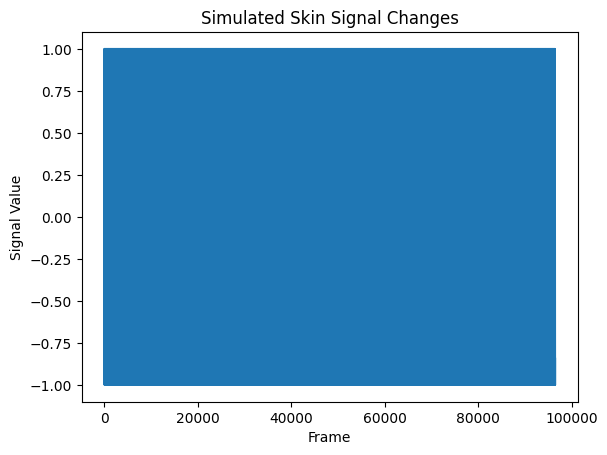

In [9]:
import cv2
import mediapipe as mp
import numpy as np
import pandas as pd
from moviepy.editor import VideoFileClip
import librosa
import librosa.display
import matplotlib.pyplot as plt
import math

# Initialize MediaPipe Pose and FaceMesh
mp_pose = mp.solutions.pose
mp_face_mesh = mp.solutions.face_mesh
pose = mp_pose.Pose(static_image_mode=False)
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=False, max_num_faces=1)

# Path to video and output
video_path = "bbb9db78-13bb-4c88-994c-c79244ce8c94_1692011832357.mp4"
audio_output_path = "/content/extracted_audio.mp3"

# Function to calculate distance between two landmarks
def calculate_distance(landmark1, landmark2):
    return math.sqrt((landmark1.x - landmark2.x)**2 + (landmark1.y - landmark2.y)**2 + (landmark1.z - landmark2.z)**2)

def process_video(video_path):
    cap = cv2.VideoCapture(video_path)
    pose_data = []
    frame_count = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Convert to RGB
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results_pose = pose.process(image)
        results_face = face_mesh.process(image)

        # Extract pose landmarks
        if results_pose.pose_landmarks:
            landmarks = results_pose.pose_landmarks.landmark
            head_tilt = calculate_distance(landmarks[mp_pose.PoseLandmark.LEFT_EYE], landmarks[mp_pose.PoseLandmark.RIGHT_EYE])
            body_movement = calculate_distance(landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER], landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER])

            # Blink detection using FaceMesh
            if results_face.multi_face_landmarks:
                face_landmarks = results_face.multi_face_landmarks[0].landmark
                left_eye_dist = calculate_distance(face_landmarks[159], face_landmarks[145])  # Eye vertical landmarks
                right_eye_dist = calculate_distance(face_landmarks[386], face_landmarks[374])
                blink_ratio = (left_eye_dist + right_eye_dist) / 2
            else:
                blink_ratio = None

            pose_data.append({
                'Frame': frame_count,
                'Head Tilt': head_tilt,
                'Body Movement': body_movement,
                'Blink Ratio': blink_ratio
            })
        frame_count += 1

    cap.release()
    return pd.DataFrame(pose_data)

def extract_audio_features(audio_path):
    """Extract pitch and tempo features from audio using Librosa."""
    y, sr = librosa.load(audio_output_path)
    tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
    pitches, magnitudes = librosa.piptrack(y=y, sr=sr)
    avg_pitch = np.mean(pitches[pitches > 0])  # Non-zero pitch
    return {'Tempo': tempo, 'Avg Pitch': avg_pitch}

def simulate_skin_signal(frames):
    """Generate synthetic skin signal changes (sinusoidal waves)."""
    return [math.sin(2 * math.pi * 0.01 * frame) for frame in range(frames)]

# Process Video and Extract Features
audio_path = extract_audio(video_path, audio_output_path)
audio_features = extract_audio_features(audio_path)
pose_df = process_video(video_path)
skin_signal = simulate_skin_signal(len(pose_df))

# Combine All Features into a DataFrame
pose_df['Skin Signal'] = skin_signal
#pose_df['Tempo'] = audio_features['Tempo']
pose_df['Avg Pitch'] = audio_features['Avg Pitch']
#pose_df['Tempo'] = audio_features['Tempo']  # Broadcasts the scalar value
#pose_df['Tempo'] = audio_features['Tempo']
#pose_df['Avg Pitch'] = audio_features['Avg Pitch']  # Broadcasts the scalar value
pose_df['Tempo'] = float(audio_features['Tempo'])  # Force as scalar
pose_df['Avg Pitch'] = float(audio_features['Avg Pitch'])  # Force as scalar
# Display Final DataFrame
print("Extracted Features DataFrame:")
print(pose_df.head())

# Save the DataFrame
df_output_path = "/content/body_language_features.csv"
pose_df.to_csv(df_output_path, index=False)
print(f"DataFrame saved to: {df_output_path}")

# Plot Skin Signal
plt.plot(pose_df['Skin Signal'])
plt.title("Simulated Skin Signal Changes")
plt.xlabel("Frame")
plt.ylabel("Signal Value")
plt.show()


In [ ]:
import librosa
import numpy as np
import pandas as pd
import parselmouth  # For jitter, shimmer, and HNR

# Replace 'input_audio_path' with your actual audio file path
audio_path = "/content/extracted_audio.mp3"

# Load the audio file
audio, sr = librosa.load(audio_path)

# Function to extract prosodic and spectral features
def extract_prosodic_spectral_features(audio, sr):
    pitch = librosa.yin(audio, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))
    features = {
        # Prosodic Features
        'mean_pitch': np.mean(pitch),
        'pitch_variability': np.std(pitch),
        'speech_rate': librosa.beat.tempo(audio, sr=sr)[0],

        # Spectral Features
        'zero_crossing_rate': np.mean(librosa.feature.zero_crossing_rate(audio)),
        'spectral_centroid': np.mean(librosa.feature.spectral_centroid(y=audio, sr=sr)),
        'spectral_bandwidth': np.mean(librosa.feature.spectral_bandwidth(y=audio, sr=sr)),
        'spectral_flatness': np.mean(librosa.feature.spectral_flatness(y=audio)),
        'spectral_rolloff': np.mean(librosa.feature.spectral_rolloff(y=audio, sr=sr)),

        # Energy and Rhythm
        'rms_energy': np.mean(librosa.feature.rms(y=audio)),
    }

    # Extract MFCCs (Mean of first 13 coefficients)
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
    for i in range(13):
        features[f'mfcc_{i+1}'] = np.mean(mfcc[i])

    return features

# Function to extract voice quality features using Praat
def extract_voice_quality_features(audio_path):
    snd = parselmouth.Sound(audio_path)
    pitch = snd.to_pitch()
    point_process = snd.to_point_process_cc()

    jitter = pitch.get_jitter(period_floor=0.0001, period_ceiling=0.02)
    shimmer = pitch.get_shimmer(period_floor=0.0001, period_ceiling=0.02)
    hnr = snd.to_harmonicity_ac().get_mean()

    return {
        'jitter': jitter,
        'shimmer': shimmer,
        'hnr': hnr
    }

# Extract all features
prosodic_spectral_features = extract_prosodic_spectral_features(audio, sr)
voice_quality_features = extract_voice_quality_features(audio_path)

# Combine all features into a single DataFrame
final_features = {**prosodic_spectral_features, **voice_quality_features}
final_features_df = pd.DataFrame([final_features])

# Save the final features to CSV
final_features_df.to_csv("final_audio_features.csv", index=False)

# Display the DataFrame
print("Final Extracted Audio Features:")
print(final_features_df)


In [3]:
#!pip install librosa numpy pandas praat-parselmouth


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 69.0 MB/s eta 0:00:00
